Week 3: Global Optimization

4.2 The potential

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
plt.rc('animation', html='jshtml') #something to do with with jupyter notebooks animation

In [10]:
#N = 50  # number of points
highlighted_dots = 5
Delta = 1  # magnitude of step size
steps = 100  # number of iterations in walk
kT = 1.0  # Temperature for the Metropolis criterion

In [11]:
#defining the potential
def V(x):
    return (-1  -np.exp(-((x+15)/10)**2) \
              -2*np.exp(-((x-10)/10)**2) + \
                -np.exp(-((x-35)/10)**2) \
              -3*np.exp(-((x-60)/10)**2) \
                -np.exp(-((x-85)/10)**2)\
              -2*np.exp(-((x-110)/10)**2) \
              ) * \
            (1+1/5*np.cos(2*np.pi/2.5*x))

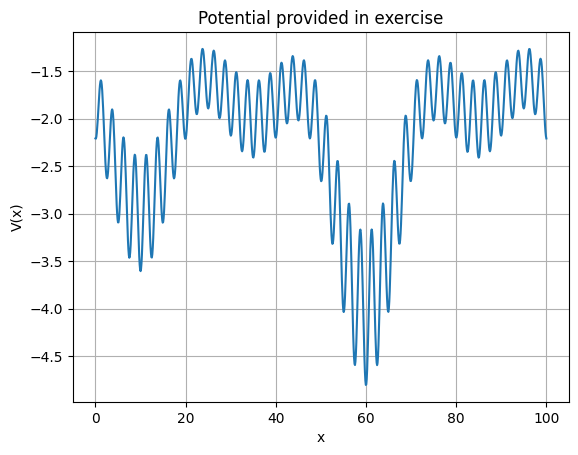

In [12]:
#plotting the potential
def plot_potential():
    x = np.linspace (0,100,1000)
    y = V(x)

    plt.plot(x,y, label='V(x)')
    plt.title('Potential provided in exercise')
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.legend
    plt.grid(True)
    plt.show

plot_potential()

4.3 Short trajectories: Metropolis MC to create a Markov chain trajectory at two different temps.

In [13]:
#metropolis sampling function specifically for the given potential in the exercise
def metropolis_sampling(x0, N, Delta,kT):
    samples = []
    current_x = x0
    for _ in range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # Random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Calculate potential energy at current and proposed positions
        current_pot = V(current_x)
        proposed_pot = V(proposed_x)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x  # Accept the move

        # Store the current position
        samples.append(current_x)

    return np.array(samples)


In [14]:
#setting up the two chains

MC_time_interval = 9
delta = 1.5
starting_x = 3

# First chain
kT_1 = 0.010
chain_1 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_1)
chain_1 = np.insert(chain_1, 0, starting_x)
MC_steps_1 = np.arange(MC_time_interval + 1)

# Second chain
kT_2 = 100.0
chain_2 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_2)
chain_2 = np.insert(chain_2, 0, starting_x)
MC_steps_2 = np.arange(MC_time_interval + 1)

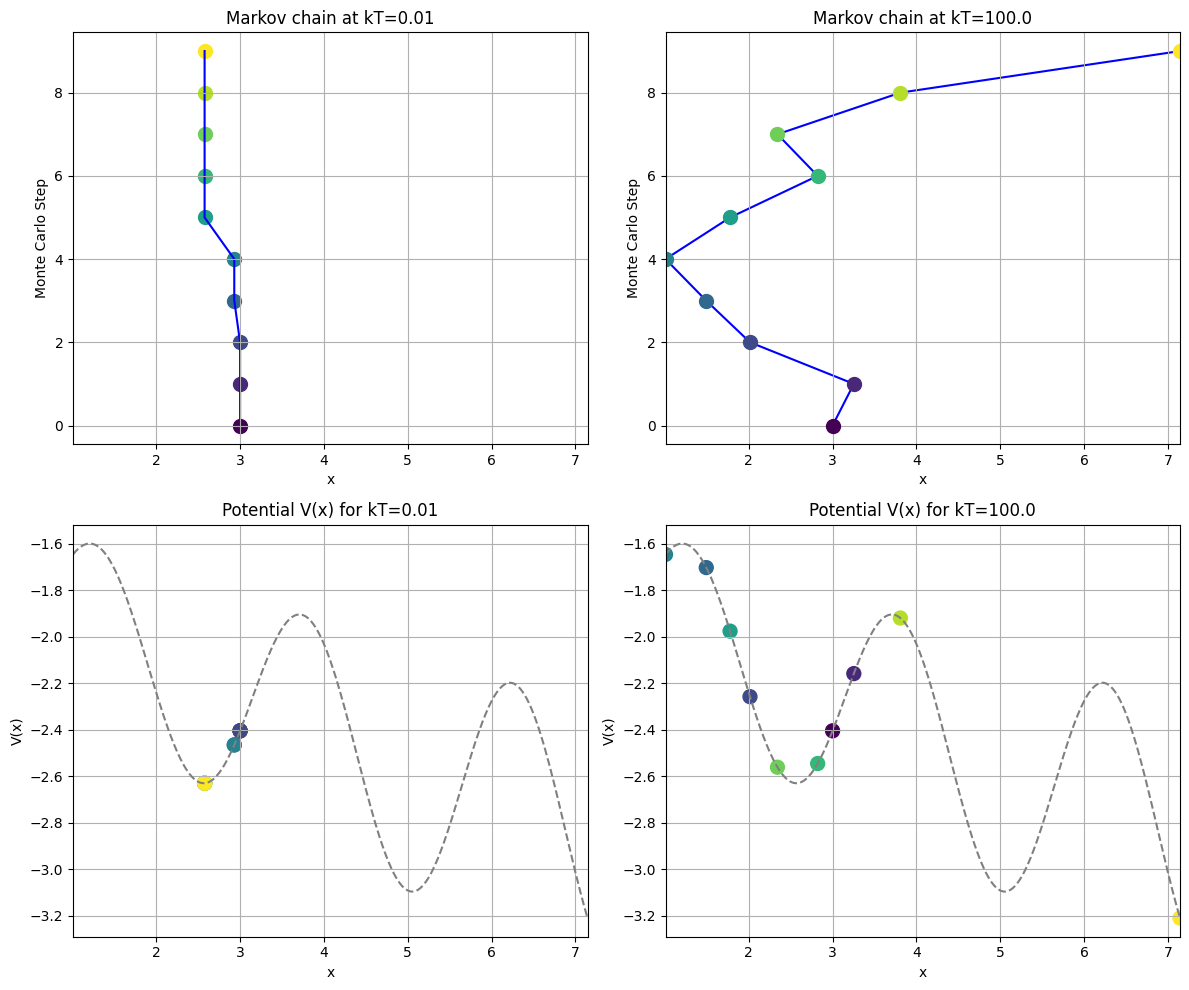

In [15]:
#actually making the 4 plots

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

x_limits = (min(min(chain_1),min(chain_2)), max(max(chain_1),max(chain_2)))
x_range = np.linspace(x_limits[0], x_limits[1], 500)
V_values = V(x_range)

#first plot 
colors_1 = plt.cm.viridis(np.linspace(0, 1, len(chain_1)))
for i in range(len(chain_1)):
    axs[0, 0].scatter(chain_1[i], MC_steps_1[i], color=colors_1[i], s=100, zorder=1)  # Larger points
axs[0, 0].plot(chain_1, MC_steps_1, linestyle='-', color='b', zorder=1)
axs[0, 0].set_title(f'Markov chain at kT={kT_1}')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Monte Carlo Step')
axs[0, 0].set_xlim(x_limits)
axs[0, 0].grid(True)

#second plot
colors_2 = plt.cm.viridis(np.linspace(0, 1, len(chain_2)))
for i in range(len(chain_2)):
    axs[0, 1].scatter(chain_2[i], MC_steps_2[i], color=colors_2[i], s=100, zorder=2)  # Larger points
axs[0, 1].plot(chain_2, MC_steps_2, linestyle='-', color='b', zorder=1)
axs[0, 1].set_title(f'Markov chain at kT={kT_2}')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Monte Carlo Step')
axs[0, 1].set_xlim(x_limits)
axs[0, 1].grid(True)

# Plot the potential energy for the first chain in the bottom left
axs[1, 0].plot(x_range, V_values, color='gray', linestyle='--', label='Potential V(x)')
axs[1, 0].scatter(chain_1, V(chain_1), color=colors_1, s=100)  # Superimpose chain_1 points with corresponding colors
axs[1, 0].set_title(f'Potential V(x) for kT={kT_1}')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('V(x)')
axs[1, 0].set_xlim(x_limits)
axs[1, 0].grid(True)

# Plot the potential energy for the second chain in the bottom right
axs[1, 1].plot(x_range, V_values, color='gray', linestyle='--', label='Potential V(x)')
axs[1, 1].scatter(chain_2, V(chain_2), color=colors_2, s=100)  # Superimpose chain_2 points with corresponding colors
axs[1, 1].set_title(f'Potential V(x) for kT={kT_2}')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('V(x)')
axs[1, 1].set_xlim(x_limits)
axs[1, 1].grid(True)


plt.tight_layout()
plt.show()

4.4 Long trajectories:
c) Start one or several low-temperature walkers and observe that they might get stuck in local minima.

In [16]:
def animate_metropolis_sampling(MC_time_interval, delta, kT_list, starting_x_list):
        
    # Ensure kT_list and starting_x_list are the same length
    assert len(kT_list) == len(starting_x_list), "kT_list and starting_x_list must have the same length"

    # Get the chain of x-values and corresponding y-values (V(x)) for each starting x
    chains = []
    for kT, starting_x in zip(kT_list, starting_x_list):
        chain = metropolis_sampling(starting_x, MC_time_interval, delta, kT)
        chain = np.insert(chain, 0, starting_x)
        chains.append((chain, V(chain)))
    
    # Combine x and y into points_in_time for each chain
    points_in_time = [list(zip(xs, ys)) for xs, ys in chains]

    # Create figure for animation
    fig, ax = plt.subplots()

    # Plot the static potential V(x)
    x_static = np.linspace(0, 100, 1000)
    y_static = V(x_static)
    ax.plot(x_static, y_static, label="V(x)", color='blue')

    # Set limits based on the data
    ax.set_xlim(min(x_static), max(x_static))
    ax.set_ylim(min(y_static), max(y_static))
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")

    scat = ax.scatter([], [], marker='o', color='red')

    # Update function for the animation
    def update(frame):
        data = np.array([points[frame] for points in points_in_time])  # Collect points for all chains
        scat.set_offsets(data)
        return [scat]

    # Create the animation
    anim = FuncAnimation(fig, update, frames=MC_time_interval+1, interval=100, blit=True)

    plt.close(fig)
    return HTML(anim.to_jshtml())

# Example usage:
animate_metropolis_sampling(50, 1, [1000, 1000], [30, 70])

4.5 Success Statistics

In [17]:
#metropolis sampling function specifically for the given potential in the exercise
def metropolis_sampling_v2(x0, Delta,kT):
    iterations = 0
    current_x = x0
    x = current_x
    while (V(x)>-4.5):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # Random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Calculate potential energy at current and proposed positions
        current_pot = V(current_x)
        proposed_pot = V(proposed_x)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x  # Accept the move
        x = current_x
        iterations += 1
        # print("iteration",iterations)
        # print("x", current_x)
        # print("V(x)", V(current_x))
        
    return current_x, iterations

low_x, iterations = metropolis_sampling_v2(50,0.1,1.0)
print("x",low_x)
print("V",V(low_x))
print("iterations",iterations)

x 57.438231290324396
V -4.570562673382053
iterations 3218


Exercise 12:
5.2 Calculator class

In [18]:
from scipy.spatial.distance import pdist

class LennardJones:
    def __init__(self, eps0=5, sigma=2**(-1/6), r_min=0.89):
        self.eps0 = eps0
        self.sigma = sigma
        self.r_min = r_min
        
    def _V(self, r):
        r = np.maximum(r,self.r_min)
        return 4 * self.eps0 * ((self.sigma / r) ** 12 - (self.sigma / r) ** 6)

    def energy(self, pos):
        distances = pdist(pos)  
        return np.sum(self._V(distances))

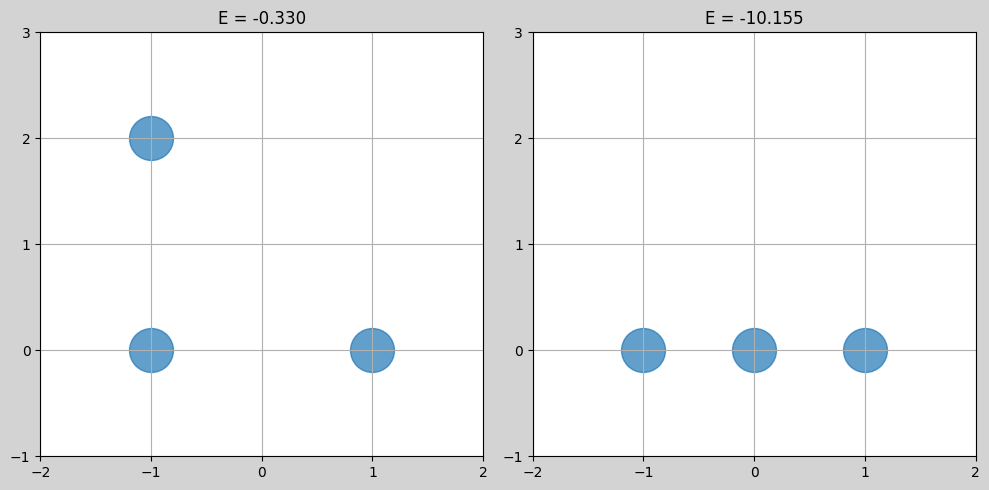

In [19]:
# plotting function for the simple setup
def plot_atoms(ax, pos, E, color):
    ax.scatter(pos[:,0], pos[:,1],s=1000, alpha=0.7)
    ax.set_xlim([-2,2])
    ax.set_ylim([-1,3])
    ax.set_xticks(np.arange(-2,3,1))
    ax.set_yticks(np.arange(-1,4,1))
    ax.grid(True)
    ax.set_title(f"E = {E:.3f}")

fig, axes = plt.subplots(1,2,figsize=(10,5))
fig.patch.set_facecolor('lightgrey')

pos1 = np.array([[-1, 2], [-1, 0], [1, 0]])
pos2 = np.array([[-1, 0], [0, 0], [1, 0]])

lj = LennardJones()
E1 = lj.energy(pos1)
E2 = lj.energy(pos2)

plot_atoms(axes[0],pos1,E1,color='orange')
plot_atoms(axes[1], pos2, E2, color='blue')

plt.tight_layout()
plt.show()

In [20]:
#testing the LennardJones class with different setups

lj = LennardJones()
pos = np.array([[100, 2], [-220, 4], [3, -100]])
print(lj.energy(pos))
pos = np.array([[-1, 0], [0, 0], [1, 0]])
print(lj.energy(pos))
pos = np.array([[-1, 0], [-1.5, 1.5], [1, 0]])
print(lj.energy(pos))

-1.340097964416143e-12
-10.155029296875
-0.7908193694742746


5.3 Energy landscape: Assume that two atoms are static and the third atom can move. Plot the total pot energy of this 3-atomic cluster as a fct of x- and y-coordinates of the third atom.

C:\Users\jacob\AppData\Local\Temp\ipykernel_13104\3579300496.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[k].legend()


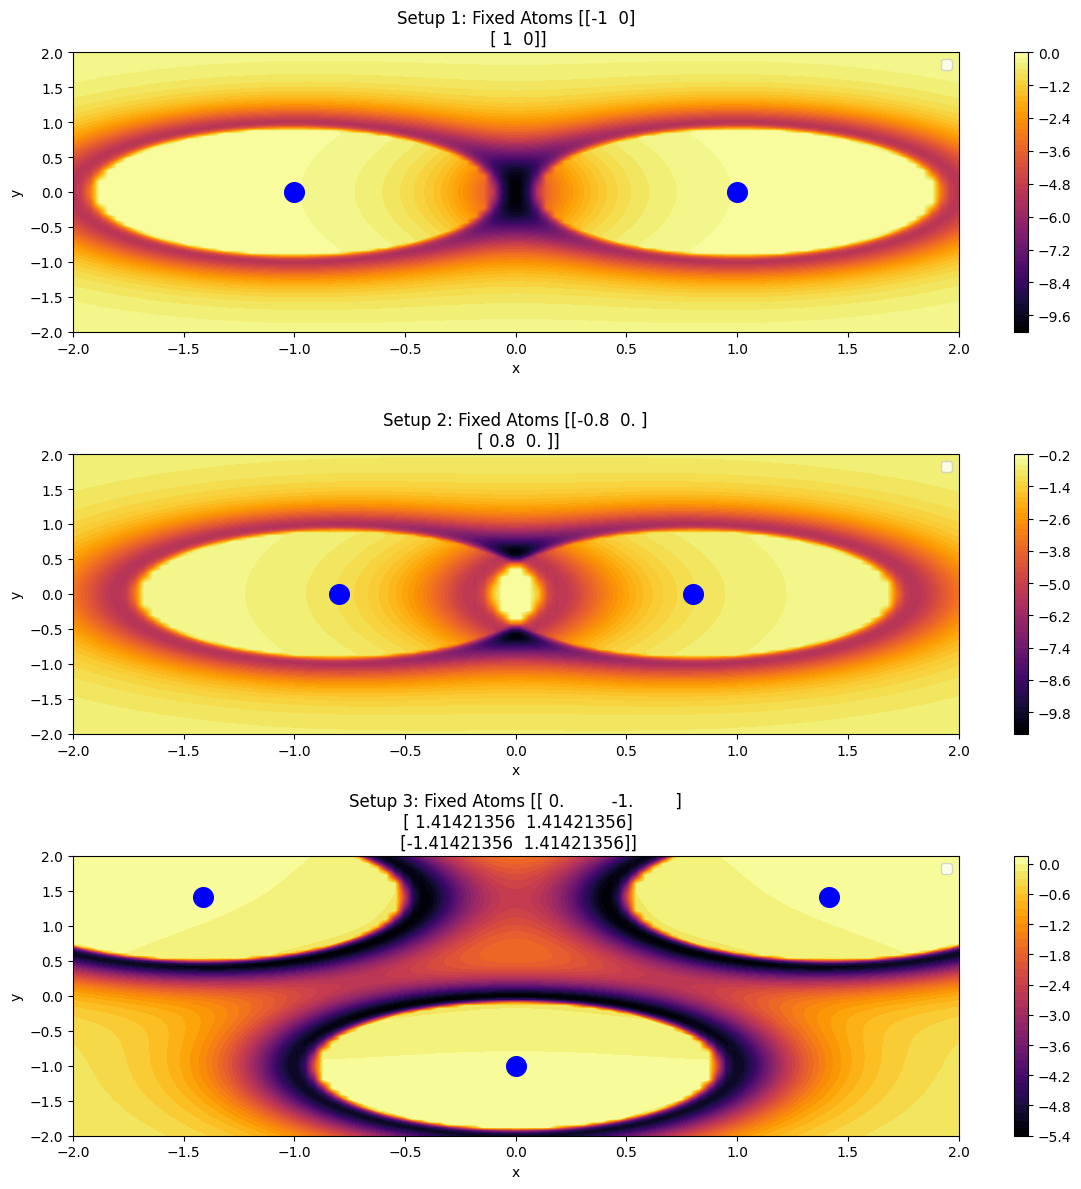

In [21]:
lj = LennardJones()

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

fixed_atoms1 = np.array([[-1, 0], [1, 0]])
fixed_atoms2 = np.array([[-0.8, 0], [0.8, 0]])
fixed_atoms3 = np.array([[0,-1],[np.sqrt(2),np.sqrt(2)],[-np.sqrt(2),np.sqrt(2)]])
fixed_setup = []
fixed_setup.append(fixed_atoms1)
fixed_setup.append(fixed_atoms2)
fixed_setup.append(fixed_atoms3)
for k in range(len(fixed_setup)):
    for i in range(len(x)):
        for j in range(len(y)):
            third_atom = np.array([[X[i, j], Y[i, j]]])  # Third atom's position
            pos = np.vstack((fixed_setup[k], third_atom))  # Combine fixed and third atom
            Z[i, j] = lj.energy(pos)  # Compute the total energy for this configuration

    contour = axes[k].contourf(X, Y, Z, levels=50, cmap='inferno')  # Filled contours
    fig.colorbar(contour, ax=axes[k])  # Add color scale to each subplot
    axes[k].scatter(fixed_setup[k][:, 0], fixed_setup[k][:, 1], color='blue', s=200)
    axes[k].set_title(f"Setup {k+1}: Fixed Atoms {fixed_setup[k]}")
    axes[k].set_xlabel("x")
    axes[k].set_ylabel("y")
    axes[k].legend()

plt.tight_layout()
plt.show()

5.4 Metropolis MC optimization: metropolis MC optimization at low temp for one of the atoms.

In [24]:
# modified Metropolis MC optimization for 2d sampling
def metropolis_sampling_2d(pot, x0y0, N, Delta,kT):
    samples = []
    current_pos = np.array([x0y0])
    fixed_atoms = np.array([[-1, 0], [1, 0]])  # Fixed atoms at two positions
    pos = np.vstack((fixed_atoms, current_pos))

    for _ in range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn(2)  # Random distribution "randn"
        proposed_pos = current_pos + Delta * RNDn
        pos_proposed = np.vstack((fixed_atoms, proposed_pos))

        # Calculate potential energy at current and proposed positions
        current_pot = pot.energy(pos)
        proposed_pot = pot.energy(pos_proposed)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        # print(proposed_pot)
        # print(current_pot)
        # print(delta_E)
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_pos = proposed_pos.copy()  # Accept the move
            pos = pos_proposed.copy()

        # Store the current position
        # print(current_pos)
        samples.append(current_pos.copy())
    return np.array(samples)


[[[ 0.0376918  -0.00717849]]

 [[-0.00660051  0.06369522]]

 [[-0.00660051  0.06369522]]

 ...

 [[ 0.00236482  0.14944684]]

 [[ 0.00236482  0.14944684]]

 [[ 0.00236482  0.14944684]]]
(10000, 1, 2)


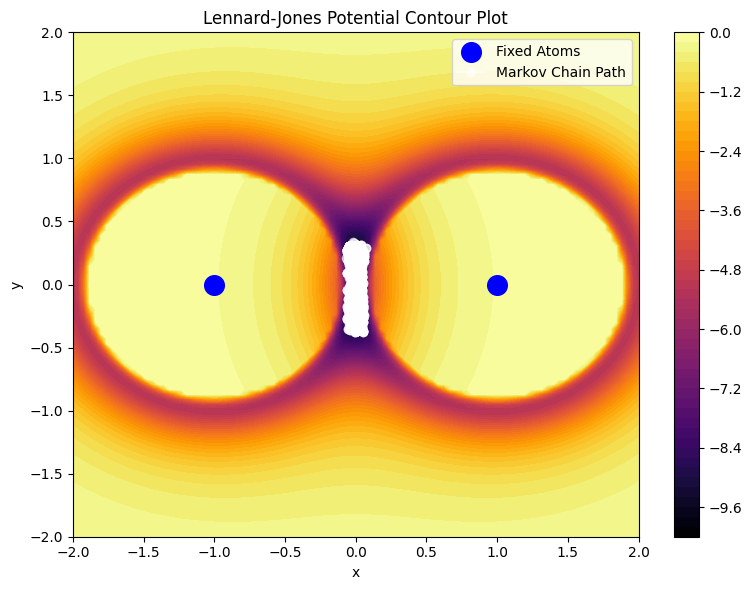

In [27]:
x0y0 = [0,0]
N = 10000
Delta = 0.1
kT = 0.2
lj = LennardJones()

samples = metropolis_sampling_2d(lj, x0y0,N,Delta,kT)
print(samples)
print(samples.shape)

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

fixed_atoms = np.array([[-1, 0], [1, 0]])

for i in range(len(x)):
    for j in range(len(y)):
        third_atom = np.array([[X[i, j], Y[i, j]]])  # Third atom position
        pos = np.vstack((fixed_atoms, third_atom))  # Combine fixed and third atom positions
        Z[i, j] = lj.energy(pos)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='inferno')  # filled contours
plt.colorbar(contour)

# Plot positions of the fixed atoms
plt.scatter(fixed_atoms[:, 0], fixed_atoms[:, 1], color='blue', s=200, label="Fixed Atoms")

# plot markov chain - sample positions
samples = samples.reshape(-1, 2)
plt.plot(samples[:, 0], samples[:, 1], 'o-', color='white', alpha=0.6, label="Markov Chain Path")


# Add labels, title, and legend
plt.title("Lennard-Jones Potential Contour Plot")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()
